# Network analysis

Caricamento della rete completa di Napoli

In [4]:
%matplotlib inline

import pickle
import osmnx as ox
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from copy import deepcopy
import folium
import os
from statistics import mean, stdev
import seaborn as sns
from copy import deepcopy
from math import log
from pathlib import Path

#estrazione delle directory per lettura e salvataggio file
parent_dir = str(Path(os.getcwd()).parent)
data_dir = os.path.join(parent_dir, 'data')
picture_dir = os.path.join(parent_dir, 'plots')
objects_dir = os.path.join(parent_dir, 'objects')
network_file_name = os.path.join(objects_dir, 'napoli.network')

with open(network_file_name, 'rb') as napoli_network_file:
    g = pickle.load(napoli_network_file)
    
nodes, edges = ox.graph_to_gdfs(g)

Calcolo le statistiche riguardanti il network

ATTENZIONE: richiede qualche minuto! Per questo motivo le statistiche sono state salvate nel file stats.dictionary e vengono caricate nella cella successiva.

CONSIGLIO: saltare questa cella e passare alla successive che caricano le statistiche da file.

In [12]:
# calcolo delle statistiche del network originale
gdf = ox.gdf_from_place('Napoli, Italia')
area = ox.project_gdf(gdf).unary_union.area
stats = ox.basic_stats(g, area=area)
extended_stats = ox.extended_stats(g, ecc=True, bc=True, cc=True)

for key, value in extended_stats.items():
    stats[key] = value
    
#aggiungo average shortest path
stats['avg_shortest_path'] = nx.average_shortest_path_length(g)
stats['avg_shortest_path_meters'] = nx.average_shortest_path_length(g, weight='length')

#si salvano le statistiche in un file
stats_file_name = os.path.join(objects_dir, 'stats.dictionary')
with open(stats_file_name, 'wb') as stats_dictionary_file:
    pickle.dump(stats, stats_dictionary_file)

Carico le statistiche da file

In [2]:
stats_file_name = os.path.join(objects_dir, 'stats.dictionary')
with open(stats_file_name, 'rb') as config_dictionary_file:
    stats = pickle.load(config_dictionary_file)

print('Number of nodes:', stats['n'])
print('Number of links:', stats['m'])
print('Average degree:', stats['k_avg'])
print('Density:', stats['m']/(stats['n']*(stats['n']-1)))
print('Average neighbor degree:', stats['avg_neighbor_degree_avg'])
print('Average degree centrality:', stats['degree_centrality_avg'])
print('Average closeness centrality:', stats['closeness_centrality_avg'])
print('Average betweenness centrality:', stats['betweenness_centrality_avg'])
print('Average clustering coefficient:', stats['clustering_coefficient_avg'])
print('Average shortest path:', stats['avg_shortest_path'])
print('Average shortest path in meters:', stats['avg_shortest_path_meters'])
print('Diameter in meters:', stats['diameter'])

Number of nodes: 7790
Number of links: 15820
Average degree: 4.061617458279846
Density: 0.00026072778651173745
Average neighbor degree: 2.210160462130941
Average degree centrality: 0.0005214555730234949
Average closeness centrality: 0.00012529905037676398
Average betweenness centrality: 0.005460386847258843
Average clustering coefficient: 0.06496240601503663
Average shortest path: 43.50050263438894
Average shortest path in meters: 7920.380285922887
Diameter in meters: 26249.469000000005


## Erdos-Renyi e Barabasi-Albert random graph

Si estraggono le reti di Erdos-Renyi e Barabasi-Albert per confrontarle con la rete stradale di Napoli

In [3]:
n_nodes = stats['n']
n_edges = stats['m']
density = n_edges/(n_nodes*(n_nodes-1))

#Erdos-Renyi Graph
er = nx.erdos_renyi_graph(n_nodes, density)
#Barabasi-Albert
ba = nx.barabasi_albert_graph(n_nodes, int(n_edges/n_nodes))

## Density

In [4]:
print('Density Napoli network: ', density)
print('Density Erdos-Renyi network: ', er.number_of_edges()/((er.number_of_nodes()*(er.number_of_nodes()-1))/2))
print('Density Barabasi-Albert network: ', ba.number_of_edges()/((ba.number_of_nodes()*(ba.number_of_nodes()-1))/2))

Density Napoli network:  0.00026072778651173745
Density Erdos-Renyi network:  0.00025683829487983036
Density Barabasi-Albert network:  0.0005134128954117349


## Grado di distribuzione

Rappresentazione del grado di distribuzione della rete di Napoli confrontata con quella dei grafi di Erdos-Renyi e Barabasi-Albert

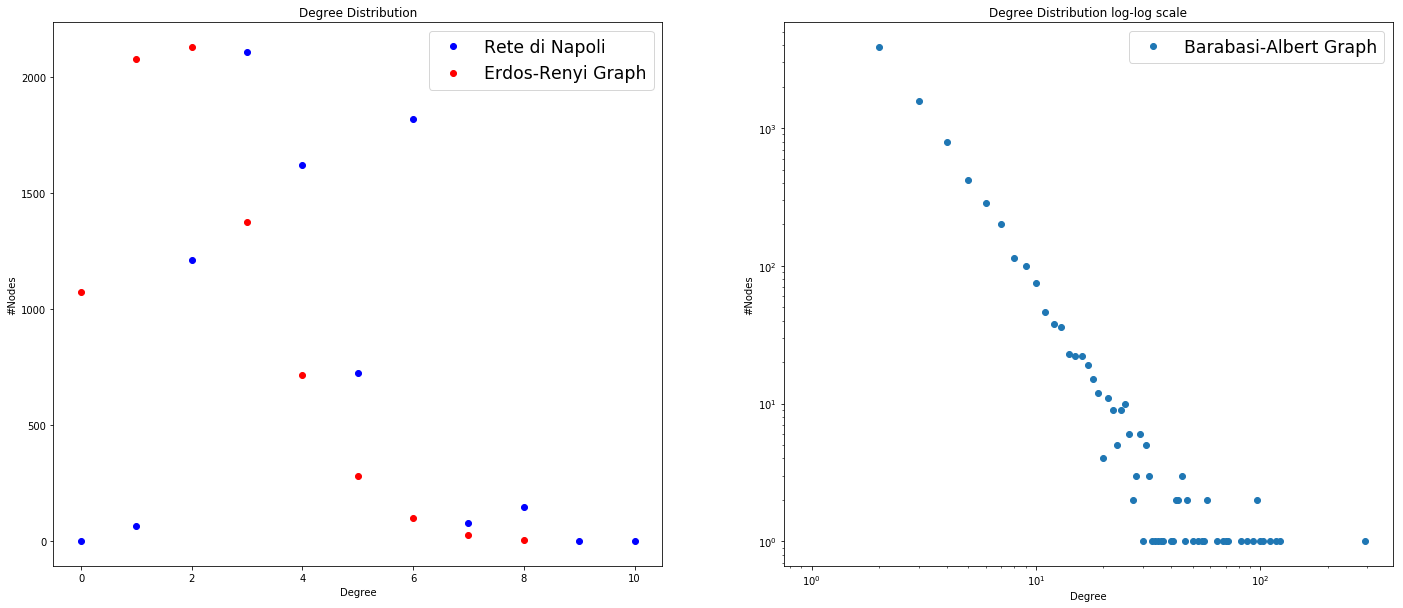

In [6]:
hist_g = nx.degree_histogram(g)
hist_er = nx.degree_histogram(er)
hist_ba = nx.degree_histogram(ba)

plt.figure(figsize=(24,10))

plt.subplot(1,2,1)
plt.plot(range(0, len(hist_g)), hist_g, "o", label='Rete di Napoli', color='b')
plt.plot(range(0, len(hist_er)), hist_er, "o", label='Erdos-Renyi Graph', color='r')

plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.legend(fontsize='xx-large')

plt.subplot(1,2,2)
plt.plot(range(0, len(hist_ba)), hist_ba, "o", label='Barabasi-Albert Graph')
plt.loglog()

plt.title("Degree Distribution log-log scale")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.legend(fontsize='xx-large')

fig_file_name = os.path.join(picture_dir, 'degree_distr')
plt.savefig(fig_file_name,bbox_inches='tight')

plt.show()

In [7]:
g_deg = dict(g.degree())
er_deg = dict(er.degree())
ba_deg = dict(ba.degree())
data = [[min(g_deg.values()),min(er_deg.values()),min(ba_deg.values())]
        ,[max(g_deg.values()),max(er_deg.values()),max(ba_deg.values())]
        ,[mean(g_deg.values()),mean(er_deg.values()),mean(ba_deg.values())]
        ,[stdev(g_deg.values()),stdev(er_deg.values()),stdev(ba_deg.values())]
        ]
print('Degree Centrality')
pd.DataFrame(data, columns=['Napoli','Erdos-Renyi','Barabasi-Albert'],index=['min','max','mean','stdev'])

Degree Centrality


,Napoli,Erdos-Renyi,Barabasi-Albert
min,1.000000,0.000000,2.000000
max,10.000000,8.000000,293.000000
mean,4.061104,2.000513,3.998973
stdev,1.549828,1.418021,6.409868


## Betwenness centrality

ATTENZIONE: richiede qualche minuto

CONSIGLIO: passare alla cella successiva che carica i risultati da file

In [10]:
betweenness_g = nx.betweenness_centrality(g)
bet_file_name = os.path.join(objects_dir, 'betweenness_g')
with open(bet_file_name, 'wb') as bet_file:
    pickle.dump(betweenness_g, bet_file)

betweenness_er = nx.betweenness_centrality(er)
bet_file_name = os.path.join(objects_dir, 'betweenness_er')
with open(bet_file_name, 'wb') as bet_file:
    pickle.dump(betweenness_er, bet_file)
    
betweenness_ba = nx.betweenness_centrality(ba)
bet_file_name = os.path.join(objects_dir, 'betweenness_ba')
with open(bet_file_name, 'wb') as bet_file:
    pickle.dump(betweenness_ba, bet_file)

Caricamento dei valori di betweenness centrality di ogni nodo

In [8]:
bet_file_name = os.path.join(objects_dir, 'betweenness_g')
with open(bet_file_name, 'rb') as bet_file:
    betweenness_g = pickle.load(bet_file)
    
bet_file_name = os.path.join(objects_dir, 'betweenness_er')
with open(bet_file_name, 'rb') as bet_file:
    betweenness_er = pickle.load(bet_file)
    
bet_file_name = os.path.join(objects_dir, 'betweenness_ba')
with open(bet_file_name, 'rb') as bet_file:
    betweenness_ba = pickle.load(bet_file)

In [9]:
data = [[min(betweenness_g.values()),min(betweenness_er.values()),min(betweenness_ba.values())]
        ,[max(betweenness_g.values()),max(betweenness_er.values()),max(betweenness_ba.values())]
        ,[mean(betweenness_g.values()),mean(betweenness_er.values()),mean(betweenness_ba.values())]
        ,[stdev(betweenness_g.values()),stdev(betweenness_er.values()),stdev(betweenness_ba.values())]
        ]
print('Betweenness Centrality')
pd.DataFrame(data, columns=['Napoli','Erdos-Renyi','Barabasi-Albert'],index=['min','max','mean','stdev'])

Betweenness Centrality


,Napoli,Erdos-Renyi,Barabasi-Albert
min,0.000000,0.000000,0.000000
max,0.206344,0.016591,0.150330
mean,0.005464,0.000868,0.000503
stdev,0.014288,0.001427,0.003569


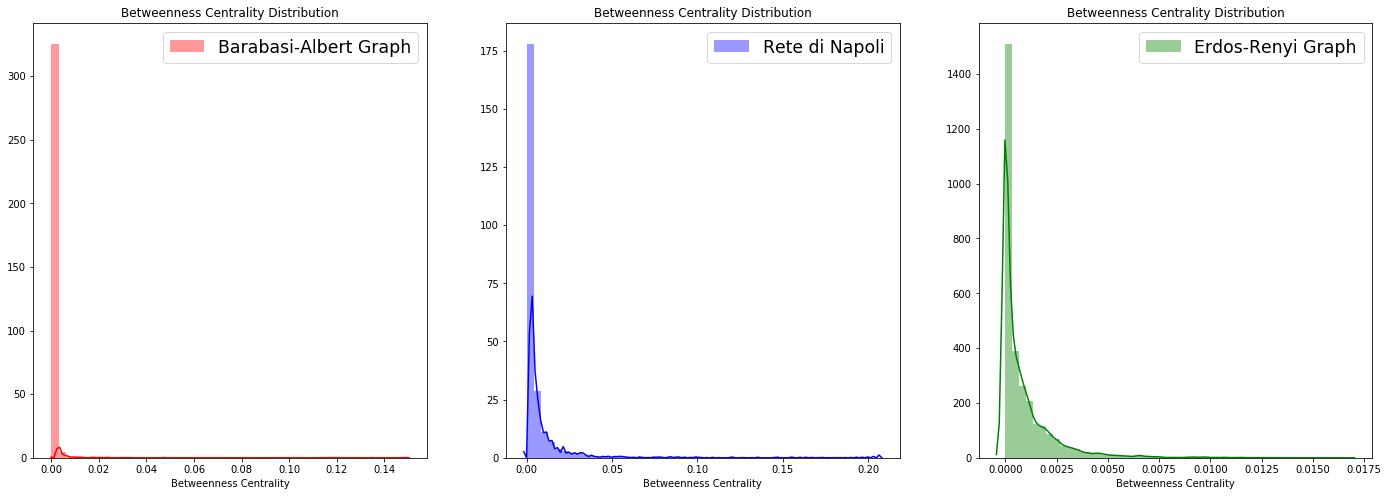

In [10]:
plt.figure(figsize=(24,8))

plt.subplot(1,3,1)
sns.distplot(list(betweenness_ba.values()),color='r', label='Barabasi-Albert Graph')
plt.title("Betweenness Centrality Distribution")
plt.xlabel("Betweenness Centrality")
plt.legend(fontsize='xx-large')

plt.subplot(1,3,2)
sns.distplot(list(betweenness_g.values()),color='b', label='Rete di Napoli')
plt.title("Betweenness Centrality Distribution")
plt.xlabel("Betweenness Centrality")
plt.legend(fontsize='xx-large')

plt.subplot(1,3,3)
sns.distplot(list(betweenness_er.values()),color='g', label='Erdos-Renyi Graph')
plt.title("Betweenness Centrality Distribution")
plt.xlabel("Betweenness Centrality")
plt.legend(fontsize='xx-large')

fig_file_name = os.path.join(picture_dir, 'betweenness')
plt.savefig(fig_file_name,bbox_inches='tight')

plt.show()

## Closness Centrality

ATTENZIONE: richiede qualche minuto

CONSIGLIO: passare alla cella successiva che carica i risultati da file

In [15]:
closeness_g = nx.closeness_centrality(g)
clos_file_name = os.path.join(objects_dir, 'closeness_g')
with open(clos_file_name, 'wb') as bet_file:
    pickle.dump(closeness_g, bet_file)

closeness_er = nx.closeness_centrality(er)
clos_file_name = os.path.join(objects_dir, 'closeness_er')
with open(clos_file_name, 'wb') as bet_file:
    pickle.dump(closeness_er, bet_file)
    
closeness_ba = nx.closeness_centrality(ba)
clos_file_name = os.path.join(objects_dir, 'closeness_ba')
with open(clos_file_name, 'wb') as bet_file:
    pickle.dump(closeness_ba, bet_file)

Caricamento dei valori di closeness centrality di ogni nodo

In [11]:
clos_file_name = os.path.join(objects_dir, 'closeness_g')
with open(clos_file_name, 'rb') as clos_file:
    closeness_g = pickle.load(clos_file)
    
clos_file_name = os.path.join(objects_dir, 'closeness_er')
with open(clos_file_name, 'rb') as clos_file:
    closeness_er = pickle.load(clos_file)
    
clos_file_name = os.path.join(objects_dir, 'closeness_ba')
with open(clos_file_name, 'rb') as clos_file:
    closeness_ba = pickle.load(clos_file)

In [12]:
data = [[min(closeness_g.values()),min(closeness_er.values()),min(closeness_ba.values())]
        ,[max(closeness_g.values()),max(closeness_er.values()),max(closeness_ba.values())]
        ,[mean(closeness_g.values()),mean(closeness_er.values()),mean(closeness_ba.values())]
        ,[stdev(closeness_g.values()),stdev(closeness_er.values()),stdev(closeness_ba.values())]
        ]
print('Closeness Centrality')
pd.DataFrame(data, columns=['Napoli','Erdos-Renyi','Barabasi-Albert'],index=['min','max','mean','stdev'])

Closeness Centrality


,Napoli,Erdos-Renyi,Barabasi-Albert
min,0.000000,0.000000,0.152397
max,0.036442,0.094711,0.322059
mean,0.022377,0.058430,0.205287
stdev,0.004443,0.029214,0.021063


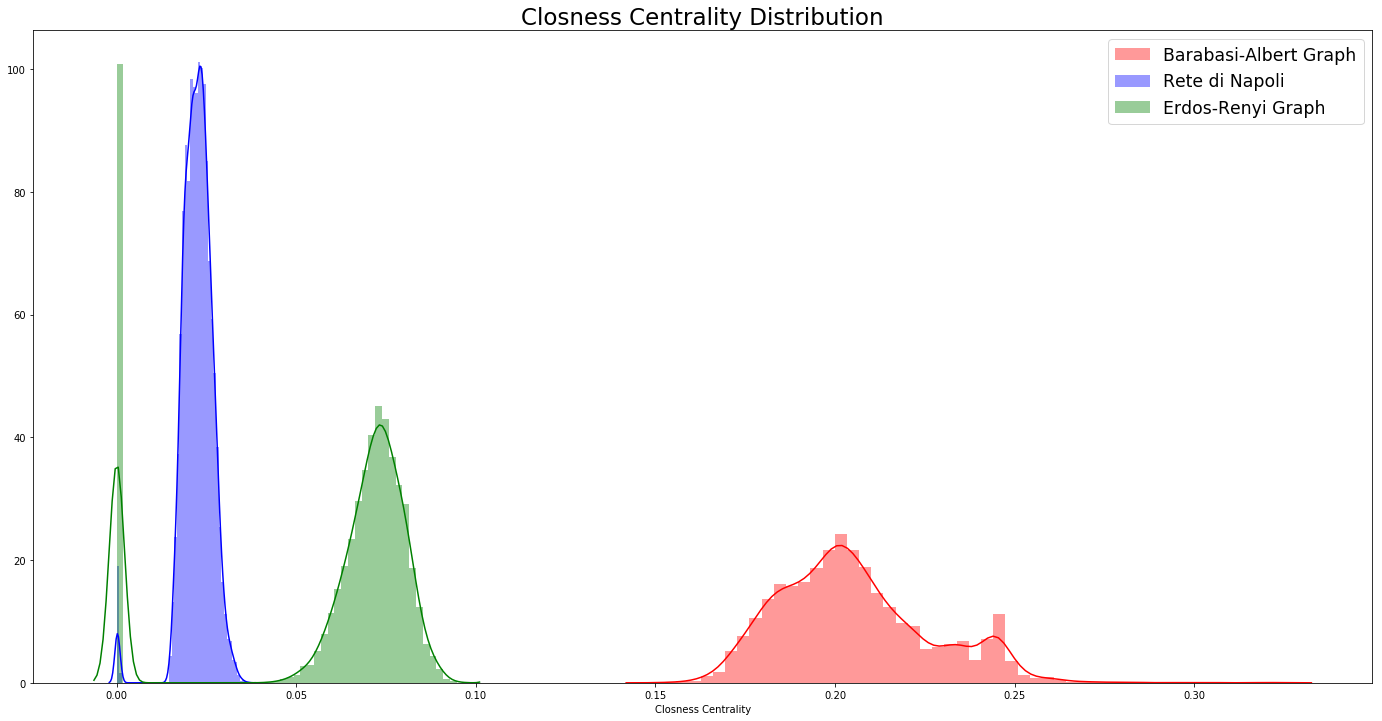

In [13]:
plt.figure(figsize=(24,12))
sns.distplot(list(closeness_ba.values()),color='r', label='Barabasi-Albert Graph')
sns.distplot(list(closeness_g.values()),color='b', label='Rete di Napoli')
sns.distplot(list(closeness_er.values()),color='g', label='Erdos-Renyi Graph')
plt.legend(fontsize='xx-large')
plt.title("Closness Centrality Distribution", {'fontsize': 23})
plt.xlabel("Closness Centrality")
fig_file_name = os.path.join(picture_dir, 'closness')
plt.savefig(fig_file_name,bbox_inches='tight')
plt.show()

## Clustering Coefficient

In [14]:
#conversione di g da multigraph a graph
G = nx.DiGraph()
for u,v,data in g.edges(data=True):
    w = data['length']# if 'length' in data else 1.0
    if not G.has_edge(u,v):
        G.add_edge(u, v, weight=w)
        
clustering_g = nx.clustering(G)
clustering_er = nx.clustering(er)
clustering_ba = nx.clustering(ba)

In [15]:
data = [[min(clustering_g.values()),min(clustering_er.values()),min(clustering_ba.values())]
        ,[max(clustering_g.values()),max(clustering_er.values()),max(clustering_ba.values())]
        ,[mean(clustering_g.values()),mean(clustering_er.values()),mean(clustering_ba.values())]
        ,[stdev(clustering_g.values()),stdev(clustering_er.values()),stdev(clustering_ba.values())]
        ]
print('Clustering Coefficient')
pd.DataFrame(data, columns=['Napoli','Erdos-Renyi','Barabasi-Albert'],index=['min','max','mean','stdev'])

Clustering Coefficient


,Napoli,Erdos-Renyi,Barabasi-Albert
min,0.000000,0.0,0.000000
max,1.000000,0.0,1.000000
mean,0.037724,0.0,0.005905
stdev,0.088563,0.0,0.067476


/home/jarir/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/jarir/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


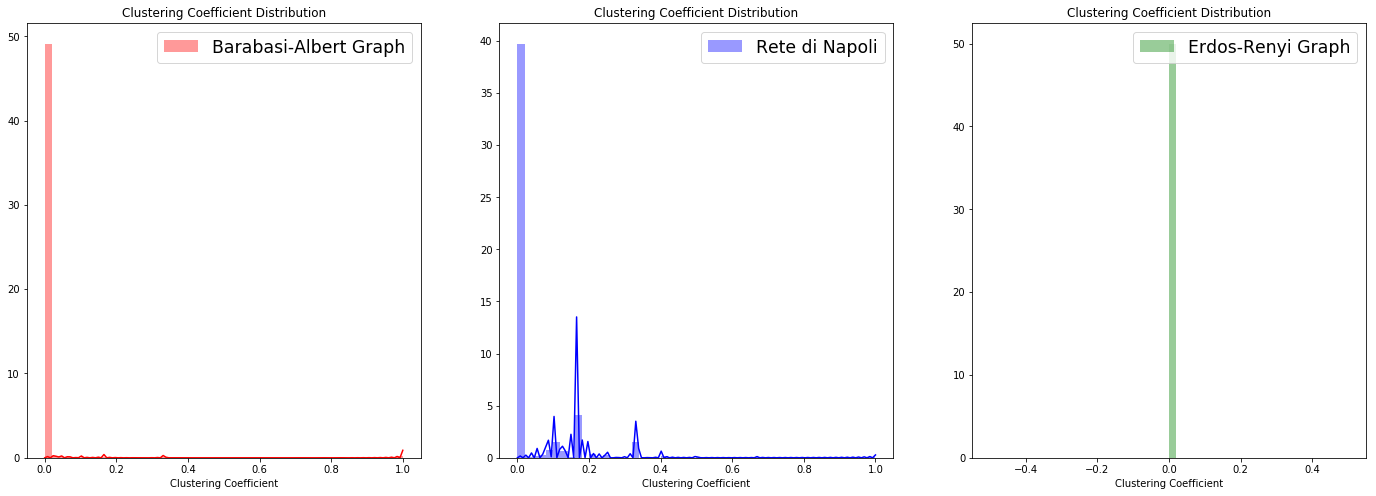

In [16]:
plt.figure(figsize=(24,8))

plt.subplot(1,3,1)
sns.distplot(list(clustering_ba.values()),color='r', label='Barabasi-Albert Graph')
plt.legend(fontsize='xx-large')
plt.title("Clustering Coefficient Distribution")
plt.xlabel("Clustering Coefficient")

plt.subplot(1,3,2)
sns.distplot(list(clustering_g.values()),color='b', label='Rete di Napoli')
plt.legend(fontsize='xx-large')
plt.title("Clustering Coefficient Distribution")
plt.xlabel("Clustering Coefficient")

plt.subplot(1,3,3)
sns.distplot(list(clustering_er.values()),color='g', label='Erdos-Renyi Graph')
plt.legend(fontsize='xx-large')
plt.title("Clustering Coefficient Distribution")
plt.xlabel("Clustering Coefficient")
fig_file_name = os.path.join(picture_dir, 'clustering')
plt.savefig(fig_file_name,bbox_inches='tight')
plt.rcParams["figure.figsize"] = [24,8]

plt.show()

## Shortest Paths

Estrazione della lunghezza dei shortest paths in metri e salvataggio su file

In [ ]:
fp = open("shortest_path_len.txt", "w" )
for x in nx.shortest_path_length(g,weight='length'):
    for text in x[1].values():
        fp.write(str(text)+'\n')
        
fp.close()

Lettura lunghezza dei shortest paths in metri e rappresentazione della distribuzione

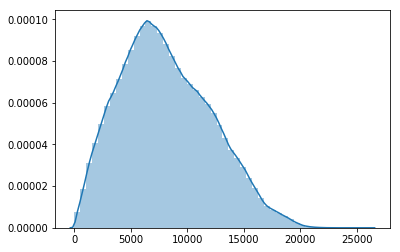

In [6]:
shortest_path = pd.read_csv('shortest_path_len.txt',header=None)
shortest_path = shortest_path.rename(columns={0:'shortest_path'})
shortest_path = shortest_path[shortest_path!=0].dropna()
sns.distplot(shortest_path)
del shortest_path

fig_file_name = os.path.join(picture_dir, 'shortest_path')
plt.savefig(fig_file_name,bbox_inches='tight')

Estrazione della lunghezza dei shortest paths del grafo g, Erdos-Renyi e Barabasi-Albert

ATTENZIONE: richiede qualche minuto

CONSIGLIO: passare alla cella successiva che carica i risultati da file

In [17]:
fp = open("shortest_path_g.txt", "w" )
for x in nx.shortest_path_length(g):
    for text in x[1].values():
        fp.write(str(text)+'\n')
        
fp.close()

fp = open("shortest_path_er.txt", "w" )
for x in nx.shortest_path_length(er):
    for text in x[1].values():
        fp.write(str(text)+'\n')
        
fp.close()

fp = open("shortest_path_ba.txt", "w" )
for x in nx.shortest_path_length(ba):
    for text in x[1].values():
        fp.write(str(text)+'\n')
        
fp.close()

Lettura lunghezza dei shortest paths e rappresentazione della distribuzione

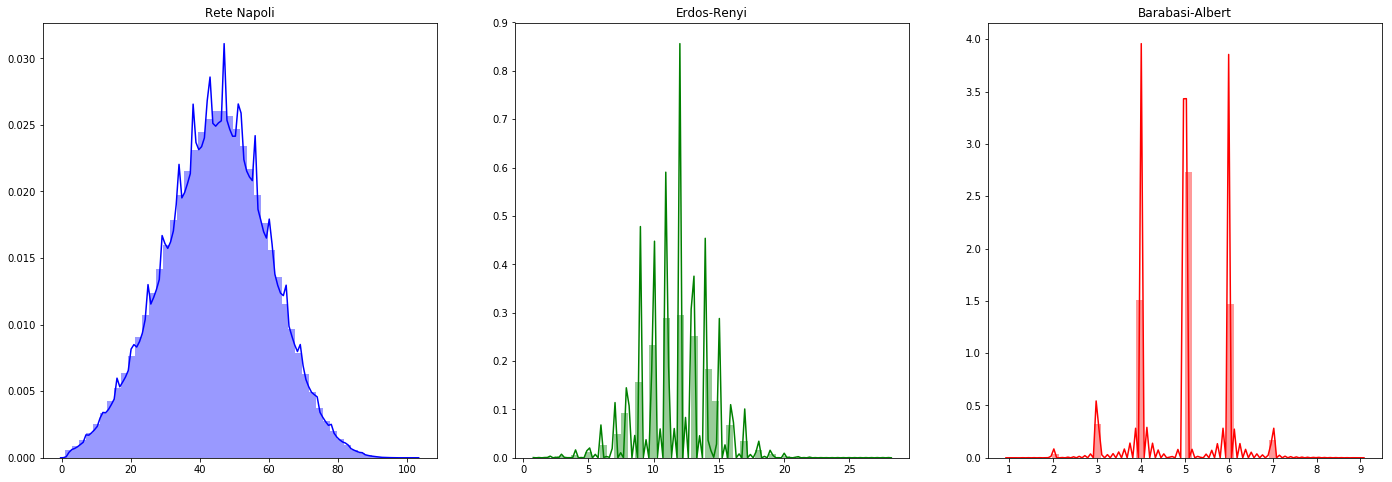

In [12]:
plt.figure(figsize=(24,8))

shortest_path_g = pd.read_csv('shortest_path_g.txt',header=None)
shortest_path_g = shortest_path_g[shortest_path_g!=0].dropna()
shortest_path_g_min = shortest_path_g.min()
shortest_path_g_max = shortest_path_g.max()
shortest_path_g_avg = shortest_path_g.mean()
shortest_path_g_std = shortest_path_g.std()
plt.subplot(1,3,1)
plt.title('Rete Napoli')
sns.distplot(shortest_path_g, color='b')
del shortest_path_g

shortest_path_er = pd.read_csv('shortest_path_er.txt',header=None)
shortest_path_er = shortest_path_er[shortest_path_er!=0].dropna()
shortest_path_er_min = shortest_path_er.min()
shortest_path_er_max = shortest_path_er.max()
shortest_path_er_avg = shortest_path_er.mean()
shortest_path_er_std = shortest_path_er.std()
plt.subplot(1,3,2)
plt.title('Erdos-Renyi')
sns.distplot(shortest_path_er, color='g')
del shortest_path_er

shortest_path_ba = pd.read_csv('shortest_path_ba.txt',header=None)
shortest_path_ba = shortest_path_ba[shortest_path_ba!=0].dropna()
shortest_path_ba_min = shortest_path_ba.min()
shortest_path_ba_max = shortest_path_ba.max()
shortest_path_ba_avg = shortest_path_ba.mean()
shortest_path_ba_std = shortest_path_ba.std()
plt.subplot(1,3,3)
plt.title('Barabasi-Albert')
sns.distplot(shortest_path_ba, color='r')
del shortest_path_ba

fig_file_name = os.path.join(picture_dir, 'shortest_path')
plt.savefig(fig_file_name,bbox_inches='tight')

In [31]:
data = [[shortest_path_g_min[0],shortest_path_er_min[0],shortest_path_ba_min[0]]
        ,[shortest_path_g_max[0],shortest_path_er_max[0],shortest_path_ba_max[0]]
        ,[shortest_path_g_avg[0],shortest_path_er_avg[0],shortest_path_ba_avg[0]]
        ,[shortest_path_g_std[0],shortest_path_er_std[0],shortest_path_ba_std[0]]
        ,[log(g.number_of_nodes())/log(mean(g_deg.values())),log(er.number_of_nodes())/log(mean(er_deg.values()))
         ,log(ba.number_of_nodes())/log(mean(ba_deg.values()))]
        ]
print('Shortest paths')
pd.DataFrame(data, columns=['Napoli','Erdos-Renyi','Barabasi-Albert'],index=['min','max','mean','stdev','log(n)/log(<k>)'])

Shortest paths


,Napoli,Erdos-Renyi,Barabasi-Albert
min,1.000000,1.000000,1.000000
max,102.000000,28.000000,9.000000
mean,44.647291,11.692744,4.922209
stdev,15.050053,2.651647,0.924366
log(n)/log(<k>),6.393782,12.818526,6.464901


## Selfloops

Rappresentiamo graficamente i selfloop per vedere a cosa corrispondono

In [5]:
import folium

start_point=[g.node[nodes.index[0]]['y'],g.node[nodes.index[0]]['x']]
m = folium.Map(
    location=start_point,
    #tiles='Stamen Toner',
    #tiles='Stamen Terrain',
    zoom_start=12
)

for i in g.selfloop_edges():
    node = i[0]
    folium.Marker(
        location=[g.node[node]['y'], g.node[node]['x']],
        icon=folium.Icon(color='green')
    ).add_to(m)
    
m